# Preparing Predicting Data & Correlation Analysis

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import prediction_prep as prep
from os import listdir
from os.path import isfile, join
import re

import warnings
warnings.filterwarnings('ignore')

sns.set_style("white")
sns.set(font_scale=1.2) 

from statsmodels.tsa.stattools import grangercausalitytests

## 1. Prepare Prediction Data

In [14]:
#DV: DIR (classf), SD (reg), Close (reg) 
# READ IN ALL DATA
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
fin_data = pd.read_csv('stock_data/PLTR_2021.csv')

# Call function to get regression df
df = prep.get_regression_df(ticker_name = 'pltr', #
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)
df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,272.0,95.0,367.0,25.885552,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,19.0,12.0,31.0,38.709553,0,291.0,145.5,NaN,107.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,341.0,130.0,471.0,27.600843,0,360.0,180.0,25.367647,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,239.0,67.0,306.0,21.895418,0,580.0,290.0,1157.894737,197.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.316741,0,0.275160
4,2021-01-05,59.0,57.0,116.0,49.137889,0,298.0,149.0,-82.697947,124.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.516378,1,-0.660916


In [15]:
df.columns

Index(['date', 'comments_neutral', 'comments_positive', 'comment_count',
       'pct_pos_comments', 'is_meme', 'comments_neutral_rollsum_2D',
       'comments_neutral_rollmean_2D', 'comments_neutral_2D_pctchg',
       'comments_positive_rollsum_2D', 'comments_positive_rollmean_2D',
       'comments_positive_2D_pctchg', 'comment_count_rollsum_2D',
       'comment_count_rollmean_2D', 'comment_count_2D_pctchg',
       'pct_pos_comments_rollsum_2D', 'pct_pos_comments_rollmean_2D',
       'pct_pos_comments_2D_pctchg', 'comments_neutral_rollsum_3D',
       'comments_neutral_rollmean_3D', 'comments_neutral_3D_pctchg',
       'comments_positive_rollsum_3D', 'comments_positive_rollmean_3D',
       'comments_positive_3D_pctchg', 'comment_count_rollsum_3D',
       'comment_count_rollmean_3D', 'comment_count_3D_pctchg',
       'pct_pos_comments_rollsum_3D', 'pct_pos_comments_rollmean_3D',
       'pct_pos_comments_3D_pctchg', 'comments_neutral_rollsum_4D',
       'comments_neutral_rollmean_4D', 'co

### 1.1 Get Lagged DF for Prediction

In [6]:
## DAILY%CHANGE ##
dep_var = ['Daily%Change'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag.head()

Check that these are all just independent financial vars: ['2D%Change', '4Dir', '5Dir', 'Low', '3Dir', 'Open', '2Dir', '3D%Change', 'High', 'Dir', '7Dir', '4D%Change', '6Dir', 'Close', 'SD', '7D%Change', 'Volume', 'SD_log', '6D%Change', '5D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Daily%Change,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_0D_pctchg(t-1),comments_positive_0D_pctchg(t-1),comment_count_0D_pctchg(t-1),pct_pos_comments_0D_pctchg(t-1),...,4D%Change(t-1),6Dir(t-1),Close(t-1),SD(t-1),7D%Change(t-1),Volume(t-1),SD_log(t-1),6D%Change(t-1),5D%Change(t-1),Daily%Change(t-1)
0,-5.188675,0,3.0,1.0,4.0,24.999375,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.492536,1,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,...,NaN,0.0,2.01,0.788105,NaN,29873800.0,-0.238123,NaN,NaN,-5.188675
2,1.515150,2,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,...,NaN,0.0,1.98,0.815720,NaN,28148300.0,-0.203684,NaN,NaN,-1.492536
3,1.990048,3,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,...,NaN,0.0,2.01,2.505572,NaN,67363300.0,0.918517,NaN,NaN,1.515150
4,4.390251,4,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,...,-3.301884,0.0,2.05,1.405905,NaN,26150500.0,0.340681,NaN,NaN,1.990048


In [7]:
## SD ##
## DAILY%CHANGE ##
dep_var = ['SD_log'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag.head()

Check that these are all just independent financial vars: ['2D%Change', '4Dir', '5Dir', 'Low', '3Dir', 'Open', '2Dir', '3D%Change', 'High', 'Dir', '7Dir', '4D%Change', '6Dir', 'Daily%Change', 'Close', 'SD', '7D%Change', 'Volume', '6D%Change', '5D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,SD_log,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_0D_pctchg(t-1),comments_positive_0D_pctchg(t-1),comment_count_0D_pctchg(t-1),pct_pos_comments_0D_pctchg(t-1),...,4D%Change(t-1),6Dir(t-1),Daily%Change(t-1),Close(t-1),SD(t-1),7D%Change(t-1),Volume(t-1),6D%Change(t-1),5D%Change(t-1),SD_log(t-1)
0,-0.238123,0,3.0,1.0,4.0,24.999375,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.203684,1,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,...,NaN,0.0,-5.188675,2.01,0.788105,NaN,29873800.0,NaN,NaN,-0.238123
2,0.918517,2,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,...,NaN,0.0,-1.492536,1.98,0.815720,NaN,28148300.0,NaN,NaN,-0.203684
3,0.340681,3,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,...,NaN,0.0,1.515150,2.01,2.505572,NaN,67363300.0,NaN,NaN,0.918517
4,0.345258,4,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,...,-3.301884,0.0,1.990048,2.05,1.405905,NaN,26150500.0,NaN,NaN,0.340681


In [8]:
## CLOSE PRICE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag.head()

Check that these are all just independent financial vars: ['2D%Change', '4Dir', '5Dir', 'Low', '3Dir', 'Open', '2Dir', '3D%Change', 'High', 'Dir', '7Dir', '4D%Change', '6Dir', 'Daily%Change', 'SD', '7D%Change', 'Volume', 'SD_log', '6D%Change', '5D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_0D_pctchg(t-1),comments_positive_0D_pctchg(t-1),comment_count_0D_pctchg(t-1),pct_pos_comments_0D_pctchg(t-1),...,4D%Change(t-1),6Dir(t-1),Daily%Change(t-1),SD(t-1),7D%Change(t-1),Volume(t-1),SD_log(t-1),6D%Change(t-1),5D%Change(t-1),Close(t-1)
0,2.01,0,3.0,1.0,4.0,24.999375,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.98,1,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,...,NaN,0.0,-5.188675,0.788105,NaN,29873800.0,-0.238123,NaN,NaN,2.01
2,2.01,2,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,...,NaN,0.0,-1.492536,0.815720,NaN,28148300.0,-0.203684,NaN,NaN,1.98
3,2.05,3,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,...,NaN,0.0,1.515150,2.505572,NaN,67363300.0,0.918517,NaN,NaN,2.01
4,2.14,4,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,...,-3.301884,0.0,1.990048,1.405905,NaN,26150500.0,0.340681,NaN,NaN,2.05


### 1.2 Check distributions of variables

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


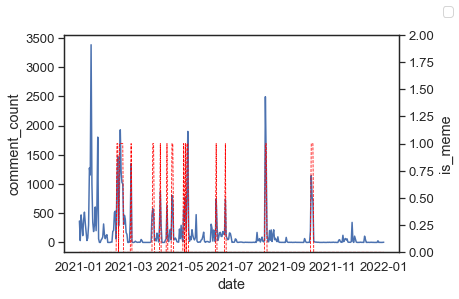

In [16]:
# Check meme period graph
ticker = 'pltr'

ax = sns.lineplot(x = 'date', y = 'comment_count', data = df, legend='auto')
ax2 = ax.twinx()
sns.lineplot(x = 'date', y = 'is_meme', data = df, legend='auto', color = 'red', linestyle="dashed", linewidth = 0.8)
ax.figure.legend()
plt.ylim(0,2)
plt.show()

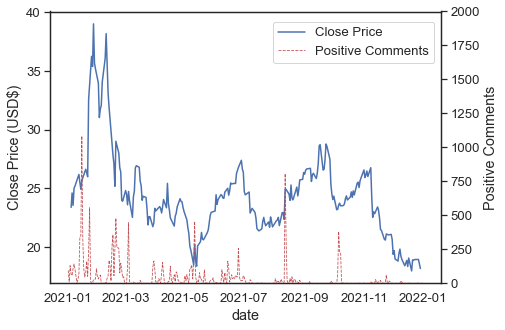

In [30]:
sns.set_style("white")
fig = plt.figure(figsize = (7,5))
ax = sns.lineplot(x = 'date', y = 'Close', data = df)
plt.ylabel('Close Price (USD$)')
ax2 = plt.twinx()
sns.lineplot(x = 'date', y = 'comments_positive', data = df, ax=ax2, color="r", linestyle='--', linewidth = 0.8)
# sns.lineplot(x = 'date', y = 'comments_neutral', data = df, ax=ax2, color="g")
plt.ylabel('Positive Comments')
plt.ylim(0, 2000)
fig.legend(labels = ['Close Price', 'Positive Comments'],
          bbox_to_anchor=(0.9, 0.87))
plt.show()

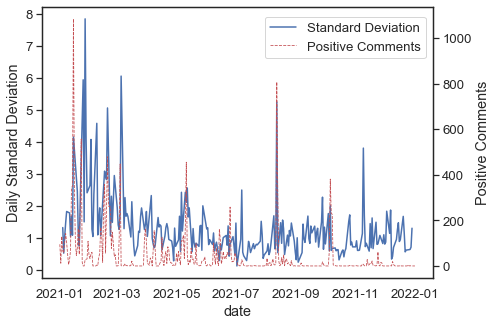

In [35]:
sns.set_style("white")
fig = plt.figure(figsize = (7,5))
ax = sns.lineplot(x = 'date', y = 'SD', data = df)
plt.ylabel('Daily Standard Deviation')
ax2 = plt.twinx()
sns.lineplot(x = 'date', y = 'comments_positive', data = df, ax=ax2, color="r", linestyle='--', linewidth = 0.8)
plt.ylabel('Positive Comments')
fig.legend(labels = ['Standard Deviation', 'Positive Comments'],
          bbox_to_anchor=(0.9, 0.87))
plt.show()

### 1.3 Distribution of Y Vars

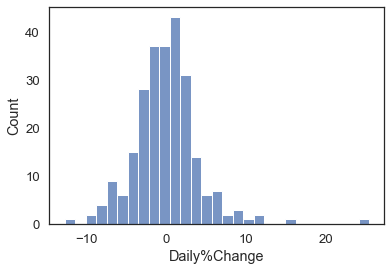

In [36]:
# Check distribution of y variable
sns.histplot(df['Daily%Change'])
plt.show()

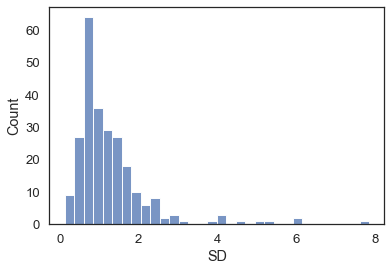

In [37]:
# Check distribution of y variable
# Need to log transform SD
sns.histplot(df['SD'])
plt.show()

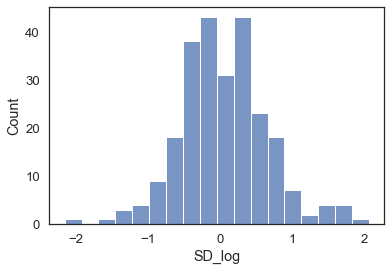

In [38]:
sns.histplot(df['SD_log'])
plt.show()

0.0    127
1.0    123
Name: Dir, dtype: int64


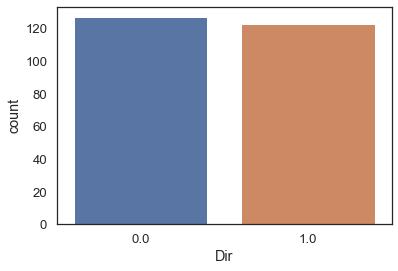

In [39]:
sns.countplot(df['Dir'])
print(df['Dir'].value_counts())
plt.show()

### 1.4 Check Comment Count

In [4]:
# Check comments and meme period for all stocks
# Get list of files
# get filenames of all tagged data files
mypath = './stock_data/'
all_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
if '.DS_Store' in all_files:
    all_files.remove('.DS_Store') # remove this line if the file is not in your path. seems to be a mac thing
print(all_files)

all_tickers = []
for i in all_files:
    match = re.search('^[A-Z]*', i)
    all_tickers.append(match[0].lower())

print(all_tickers)

['BB_2021.csv', 'WISH_2021.csv', 'FB_2021.csv', 'NOK_2021.csv', 'TSLA_2021.csv', 'PLTR_2021.csv', 'META_2021.csv', 'AMZN_2021.csv', 'AMC_2021.csv', 'CLOV_2021.csv']
['bb', 'wish', 'fb', 'nok', 'tsla', 'pltr', 'meta', 'amzn', 'amc', 'clov']


In [5]:
# For file, ticker
comment_count_2021 = []
meme_days_2021 = []
for file, ticker in zip(all_files, all_tickers):
    comments = pd.read_csv('comments_preprocessed_assigned.csv')
    sentiment = pd.read_csv('df_pred_id_body.csv')
    fin_data = pd.read_csv(mypath+file)
    
    # Call function to get regression df
    df = prep.get_regression_df(ticker_name = ticker, 
                               comments = comments, 
                               fin_data = fin_data,
                               sentiment = sentiment)
    
    comment_count = sum(df['comment_count'])
    meme_days = sum(df['is_meme'])
    
    comment_count_2021.append(comment_count)
    meme_days_2021.append(meme_days)

In [6]:
# Report comment count and meme days
df_for_report = pd.DataFrame.from_dict({'ticker': all_tickers,
                                       'comment_count': comment_count_2021,
                                       'meme_days': meme_days_2021})
df_for_report

,ticker,comment_count,meme_days
0,bb,191964.0,14
1,wish,62550.0,21
2,fb,1989.0,22
3,nok,27000.0,16
4,tsla,51175.0,26
5,pltr,57065.0,25
6,meta,3202.0,18
7,amzn,11314.0,24
8,amc,232100.0,20
9,clov,127854.0,22


## 2. Correlation and Time Series Tests

The Null hypothesis is: the series in the second column, does not Granger cause the series in the first. 

If the P-Values are less than a significance level (0.05) then you reject the null hypothesis and conclude that the said lag of X is indeed useful.

### 2.1. Granger Causality Test

In [19]:
# Get list of files
# get filenames of all tagged data files
mypath = './stock_data/'
all_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
if '.DS_Store' in all_files:
    all_files.remove('.DS_Store') # remove this line if the file is not in your path. seems to be a mac thing
print(all_files)

all_tickers = []
for i in all_files:
    match = re.search('^[A-Z]*', i)
    all_tickers.append(match[0].lower())

print(all_tickers)

all_dep_vars = ['Daily%Change', 'SD', 'Close']
all_indep_vars = ['comment_count', 'comments_positive', 'comment_count_rollmean_3D', 'comments_positive_rollmean_3D']

['BB_2021.csv', 'WISH_2021.csv', 'FB_2021.csv', 'NOK_2021.csv', 'TSLA_2021.csv', 'PLTR_2021.csv', 'META_2021.csv', 'AMZN_2021.csv', 'AMC_2021.csv', 'CLOV_2021.csv']
['bb', 'wish', 'fb', 'nok', 'tsla', 'pltr', 'meta', 'amzn', 'amc', 'clov']


In [20]:
# Run for loop to get data

# For file, ticker
results = []

for file, ticker in zip(all_files, all_tickers):
    comments = pd.read_csv('comments_preprocessed_assigned.csv')
    sentiment = pd.read_csv('df_pred_id_body.csv')
    fin_data = pd.read_csv(mypath+file)

    # Call function to get regression df
    df = prep.get_regression_df(ticker_name = ticker, 
                               comments = comments, 
                               fin_data = fin_data,
                               sentiment = sentiment)
    
    # For all 3 variables
    for dep_var in all_dep_vars:
        
        for indep_var in all_indep_vars:
            test_df = df[[dep_var, indep_var]].dropna()
            gct = pd.DataFrame(grangercausalitytests(test_df, maxlag = [1, 2, 3, 4, 5, 6, 7], verbose = None))

            for lag in range(7):
                ssr_ftest = gct.iloc[0,lag]['ssr_ftest'][1]
                ssr_chi2test = gct.iloc[0,lag]['ssr_chi2test'][1]
                pretty_result = [ticker, dep_var, indep_var, lag, ssr_ftest, ssr_chi2test]
                
                results.append(pretty_result)

In [21]:
gct_results_df = pd.DataFrame(results)
gct_results_df.columns = ['ticker', 'y_var', 'x_var', 'lag', 'ssr_ftest', 'ssr_chi2test']

In [22]:
# gct_results_df.to_csv('Granger_Causality_Results.csv', index = False)

In [23]:
# Lag subset
subset = gct_results_df[['ticker', 'ssr_ftest','lag']]